## 대류 열전달 계수 적용하지 않기, 수식 변경

In [1]:
!nvidia-smi

Tue Feb 18 16:21:51 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:19:00.0 Off |                  N/A |
|  0%   24C    P8              25W / 350W |   6582MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch import Tensor
from pyDOE import lhs
from function_facc2 import *

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

device = torch.device('cuda:0' if torch.cuda.is_available() else ' cpu')
print(device)

cuda:0


In [3]:
import random
import numpy as np
import torch

seed = 0
deterministic = True

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
if deterministic:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [6]:
rho = 1 # density
mu = 0.01 # viscosity
k_fluid = 0.1 # thermal conductivity
inlet = 1
temp = 10
k_solid = 10 
cp = 50 # specific heat capacity
thermal_diffusivity = k_fluid / (rho * cp)
k_mu = mu / rho # kinematic viscosity

density_surface = 20000 # 단위 면적당 개수
density_line =  1000

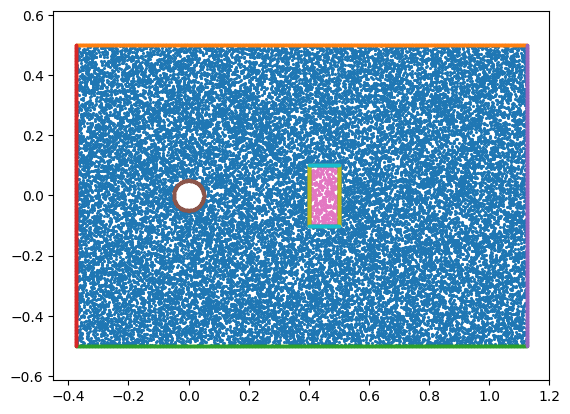

(36373, 3)


In [7]:
collocation_points = COLLOCATION_POINTS2(density_surface, density_line)
print(collocation_points.shape)

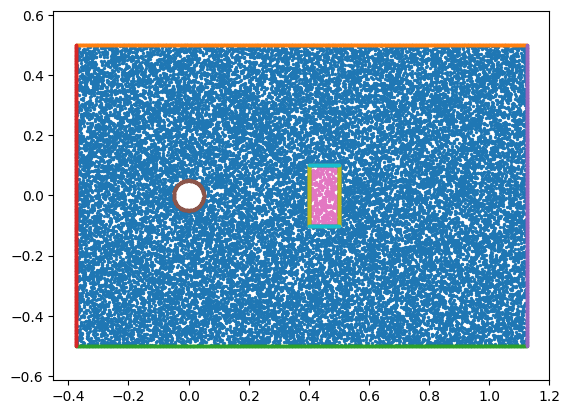

In [8]:
collocation_indexing = {'domain_fluid': 0, 'bc_fluid_top': 1, 'bc_fluid_bottom': 2, 'bc_fluid_left': 3, 
                            'bc_fluid_right': 4, 'bc_cylinder': 5, 'domain_saga': 6, 'bc_saga': 7, 'sb1': 8, 'sb2': 9}

data = collocation_points[:, 1:]
label = collocation_points[:, 0]
for i in range(10):
    a = data[np.where(label == i)]
    plt.scatter(a[:, 0], a[:, 1], s=2)
    # else:
    # plt.scatter(a[:, 0], a[:, 1], s=2)
plt.axis('equal') 
plt.show()

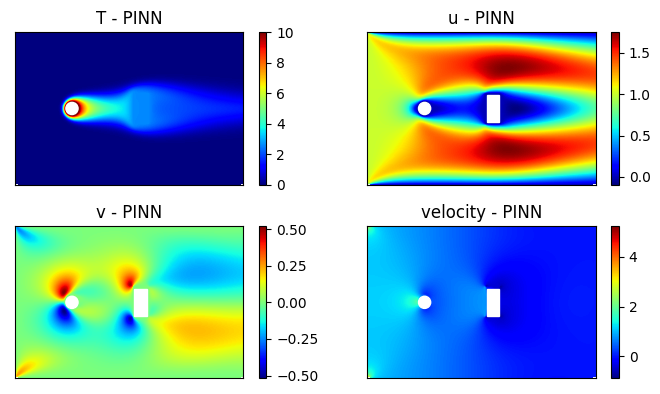

In [9]:
import scipy.interpolate
import matplotlib.patches as patches

cor_fluid = np.loadtxt("./CFD/mu_01_50/xy_cor_fluid.txt")
cor_saga = np.loadtxt("./CFD/mu_01_50/xy_cor_saga.txt")
# cor[:, 0] = cor[:, 0] - 0.5
# cor[:, 1] = cor[:, 1] - 0.5

u_fluid = np.loadtxt("./CFD/mu_01_50/u_fluid.txt")
v_fluid = np.loadtxt("./CFD/mu_01_50/v_fluid.txt")
p_fluid = np.loadtxt("./CFD/mu_01_50/p_fluid.txt")
T_fluid = np.loadtxt("./CFD/mu_01_50/T_fluid.txt") - 273.15
T_saga = np.loadtxt("./CFD/mu_01_50/T_saga.txt") - 273.15

u_fluid_max, u_fluid_min = np.max(u_fluid), np.min(u_fluid)
v_fluid_max, v_fluid_min = np.max(v_fluid), np.min(v_fluid)
p_fluid_max, p_fluid_min = np.max(p_fluid), np.min(p_fluid)
T_fluid_max, T_fluid_min = np.max(T_fluid), np.min(T_fluid)
T_saga_max, T_saga_min = np.max(T_saga), np.min(T_saga)

vel_CFD = np.sqrt(u_fluid**2 + v_fluid**2)
vel_CFD_max = np.max(vel_CFD)
vel_CFD_min = np.min(vel_CFD)

CFD_results_fluid = np.vstack([u_fluid, v_fluid, p_fluid, T_fluid]).T
CFD_results_saga = T_saga.reshape(-1 ,1)

def interpolate_output(x, y, us, extent):
    "Interpolates irregular points onto a mesh"

    # define mesh to interpolate onto
    xyi = np.meshgrid(
        np.linspace(extent[0], extent[1], 500),
        np.linspace(extent[2], extent[3], 500),
        indexing="ij",
    )

    # linearly interpolate points onto mesh
    us = [scipy.interpolate.griddata(
        (x, y), u, tuple(xyi)
        )
        for u in us]

    return us

def plot(cor_fluid, cor_saga):
    x, y = cor_fluid[:, 0], cor_fluid[:, 1]

    T_inter, u_inter, v_inter, p_inter = interpolate_output(x, y,
                                                           [T_fluid.reshape(-1, 1), u_fluid.reshape(-1, 1), v_fluid.reshape(-1, 1), p_fluid.reshape(-1, 1)],
                                                           [-0.375, 1.125, -0.5, 0.5],
    )

    T_inter = T_inter.squeeze(axis=2)
    u_inter = u_inter.squeeze(axis=2)
    v_inter = v_inter.squeeze(axis=2)
    p_inter = p_inter.squeeze(axis=2)
    
    plt.figure(figsize=(7, 4))
    plt.subplot(2, 2, 1)
    plt.title('T - PINN')
    plt.imshow(T_inter.T, origin="lower", extent=[-0.375, 1.125, -0.5, 0.5], vmin=0, vmax=10, cmap='jet')
    shp=patches.Circle((0, 0), radius=0.04, color='white')
    plt.gca().add_patch(shp)
    plt.colorbar()
    plt.gca().axes.xaxis.set_visible(False)
    plt.gca().axes.yaxis.set_visible(False)

    plt.subplot(2, 2, 2)
    plt.title('u - PINN')
    plt.imshow(u_inter.T, origin="lower", extent=[-0.375, 1.125, -0.5, 0.5], vmin=u_fluid_min, vmax=u_fluid_max, cmap='jet')
    shp=patches.Circle((0, 0), radius=0.04, color='white')
    plt.gca().add_patch(shp)
    shp=patches.Rectangle((0.41, -0.09), 0.08, 0.18, color='white')
    plt.gca().add_patch(shp)
    plt.colorbar()
    plt.gca().axes.xaxis.set_visible(False)
    plt.gca().axes.yaxis.set_visible(False)

    plt.subplot(2, 2, 3)
    plt.title('v - PINN')
    plt.imshow(v_inter.T, origin="lower", extent=[-0.375, 1.125, -0.5, 0.5], vmin=v_fluid_min, vmax=v_fluid_max, cmap='jet')
    shp=patches.Circle((0, 0), radius=0.04, color='white')
    plt.gca().add_patch(shp)
    shp=patches.Rectangle((0.41, -0.09), 0.08, 0.18, color='white')
    plt.gca().add_patch(shp)
    plt.colorbar()
    plt.gca().axes.xaxis.set_visible(False)
    plt.gca().axes.yaxis.set_visible(False)

    plt.subplot(2, 2, 4)
    plt.title('velocity - PINN')
    plt.imshow(p_inter.T, origin="lower", extent=[-0.375, 1.125, -0.5, 0.5], vmin=p_fluid_min, vmax=p_fluid_max, cmap='jet')
    shp=patches.Circle((0, 0), radius=0.04, color='white')
    plt.gca().add_patch(shp)
    shp=patches.Rectangle((0.41, -0.09), 0.08, 0.18, color='white')
    plt.gca().add_patch(shp)
    plt.colorbar()
    plt.gca().axes.xaxis.set_visible(False)
    plt.gca().axes.yaxis.set_visible(False)
    plt.tight_layout()
    # plt.savefig('./image/facc_pinn_v4_01_50/facc_pinn_v4.png'.format(epoch),format='png', dpi=100, bbox_inches='tight', pad_inches=0)
    plt.show()

plot(cor_fluid, cor_saga)

In [10]:
def PDE_F1(model1, collocation_points):
    X = collocation_points.copy()
    X = torch.tensor(X, requires_grad=True)
    
    idx_domain_fluid = np.where(X[:, 0] == 0)
    colp_domain_fluid = X[idx_domain_fluid][:, 1:].to(device)
    Domain_fluid = model1(colp_domain_fluid)
    
    u = Domain_fluid[:, 0]
    v = Domain_fluid[:, 1]
    p = Domain_fluid[:, 2]

    u_x_y = autograd.grad(u, colp_domain_fluid, torch.ones(u.shape).to(device), retain_graph = True, create_graph = True)[0]
    du_x = u_x_y[:, 0:1]
    du_y = u_x_y[:, 1:2]
    
    u_xx_xy = autograd.grad(du_x, colp_domain_fluid, torch.ones(du_x.shape).to(device), retain_graph = True, create_graph = True)[0]
    u_yx_yy = autograd.grad(du_y, colp_domain_fluid, torch.ones(du_y.shape).to(device), retain_graph = True, create_graph = True)[0]
    
    v_x_y = autograd.grad(v, colp_domain_fluid, torch.ones(v.shape).to(device), retain_graph = True, create_graph = True)[0]
    dv_x = v_x_y[:, [0]]
    dv_y = v_x_y[:, [1]]
    
    v_xx_xy = autograd.grad(dv_x, colp_domain_fluid, torch.ones(dv_x.shape).to(device), create_graph = True)[0]
    v_yx_yy = autograd.grad(dv_y, colp_domain_fluid, torch.ones(dv_y.shape).to(device), create_graph = True)[0]
    
    p_x_y = autograd.grad(p, colp_domain_fluid, torch.ones(p.shape).to(device), create_graph = True)[0]
    
    du_xx = u_xx_xy[:, [0]]
    du_yy = u_yx_yy[:, [1]]
    
    dv_xx = v_xx_xy[:, [0]]
    dv_yy = v_yx_yy[:, [1]]
    
    dp_x = p_x_y[:, [0]]
    dp_y = p_x_y[:, [1]]
    
    u = u.reshape(-1, 1)
    v = v.reshape(-1, 1)

    pde_u = rho * (u * du_x + v * du_y) + dp_x - mu * (du_xx + du_yy)
    pde_v = rho * (u * dv_x + v * dv_y) + dp_y - mu * (dv_xx + dv_yy)
    pde_cont = du_x + dv_y
    
    return [pde_u.float(), pde_v.float(),  pde_cont.float()]

def PDE_F2(model1, model2, collocation_points):
    X = collocation_points.copy()
    X = torch.tensor(X, requires_grad=True)
    
    idx_domain_fluid = np.where(X[:, 0] == 0)
    colp_domain_fluid = X[idx_domain_fluid][:, 1:].to(device)
    
#     with torch.no_grad():
#         model1.eval()
    Domain_fluid1 = model1(colp_domain_fluid)
    
    Domain_fluid2 = model2(colp_domain_fluid)
    
    u = Domain_fluid1[:, 0:1]
    v = Domain_fluid1[:, 1:2]
    T = Domain_fluid2[:, 0:1]
    
    u_x_y = autograd.grad(u, colp_domain_fluid, torch.ones(u.shape).to(device), retain_graph = True, create_graph = True)[0]
    du_x = u_x_y[:, 0:1]
    du_y = u_x_y[:, 1:2]
    
    T_x_y = autograd.grad(T, colp_domain_fluid, torch.ones(T.shape).to(device), retain_graph=True, create_graph=True)[0]
    dT_x = T_x_y[:, 0:1]
    dT_y = T_x_y[:, 1:2]
    
    T_xx_xy = autograd.grad(dT_x, colp_domain_fluid, torch.ones(dT_x.shape).to(device), retain_graph=True, create_graph=True)[0]
    dT_xx = T_xx_xy[:, 0:1]
    
    T_yx_yy = autograd.grad(dT_y, colp_domain_fluid, torch.ones(dT_y.shape).to(device), retain_graph=True, create_graph=True)[0]
    dT_yy = T_yx_yy[:, 1:2]
    
#     u = u.detach()
#     v = v.detach()
#     du_y = du_y.detach()
    
    pde_t = (u * dT_x + v * dT_y) - thermal_diffusivity * (dT_xx + dT_yy) #- (k_mu/cp) * du_y**2
    
    return [pde_t.float()]

def PDE_S(model3, collocation_points):
    X = collocation_points.copy()
    X = torch.tensor(X, requires_grad=True)
    
    idx_domain_solid = np.where(X[:, 0] == 6)[0]
    
    colp_domain_solid = X[idx_domain_solid][:, 1:].to(device)
    
    Domain_solid = model3(colp_domain_solid)
    
    T = Domain_solid[:, 0:1]
                    
    T_x_y = torch.autograd.grad(T, colp_domain_solid, torch.ones(T.shape).to(device), retain_graph=True, create_graph=True)[0]
    dT_x = T_x_y[:, 0:1]
    dT_y = T_x_y[:, 1:2]
    
    T_xx_yx = torch.autograd.grad(dT_x, colp_domain_solid, torch.ones(dT_x.shape).to(device), retain_graph=True, create_graph=True)[0]
    dT_xx = T_xx_yx[:, 0:1]
    
    T_xy_yy = torch.autograd.grad(dT_y, colp_domain_solid, torch.ones(dT_y.shape).to(device), retain_graph=True, create_graph=True)[0]
    dT_yy = T_xy_yy[:, 1:2]
                    
    pde_t = k_solid * (dT_xx + dT_yy)
                    
    return [pde_t.float()]

def BC_F(model1, collocation_points, inlet):
    X = collocation_points.copy()
    X = torch.tensor(X, requires_grad=True)
    idx_bc_top = np.where(X[:, 0] == 1)[0]
    idx_bc_bottom = np.where(X[:, 0] == 2)[0]
    idx_bc_left = np.where(X[:, 0] == 3)[0]
    idx_bc_right = np.where(X[:, 0] == 4)[0]
    idx_bc_cylinder = np.where(X[:, 0] == 5)[0]
    idx_bc_saga = np.where(X[:, 0] == 7)[0]
    colp_bc = X[:, 1:].to(device)
    colp_bc_right = X[idx_bc_right][:, 1:].to(device)
    
    BC_top = model1(colp_bc[idx_bc_top])[:, 0:2]
    BC_bottom = model1(colp_bc[idx_bc_bottom])[:, 0:2]
    BC_left_u = model1(colp_bc[idx_bc_left])[:, 0] - torch.ones_like(model1(colp_bc[idx_bc_left])[:, 0]) * inlet
    BC_left_v = model1(colp_bc[idx_bc_left])[:, 1]
    BC_right = model1(colp_bc[idx_bc_right])[:, 2] 
    BC_cylinder = model1(colp_bc[idx_bc_cylinder])[:, 0:2]
    BC_saga = model1(colp_bc[idx_bc_saga])[:, 0:2]
    
    return [BC_top.float(), BC_bottom.float(), BC_left_u.float(), BC_left_v.float(), 
            BC_right.float(), BC_cylinder.float(), BC_saga.float()]

def BC_T(model2, collocation_points):
    X = collocation_points.copy()
    X = torch.tensor(X, requires_grad=True)
    idx_bc_top = np.where(X[:, 0] == 1)[0]
    idx_bc_bottom = np.where(X[:, 0] == 2)[0]
    idx_bc_left = np.where(X[:, 0] == 3)[0]
    idx_bc_right = np.where(X[:, 0] == 4)[0]
    idx_bc_cylinder = np.where(X[:, 0] == 5)[0]
    idx_bc_saga = np.where(X[:, 0] == 7)[0]
    colp_bc = X[:, 1:].to(device)
    colp_bc_right = X[idx_bc_right][:, 1:].to(device)
    
    T_top = model2(colp_bc[idx_bc_top])[:, 0]
    T_bottom = model2(colp_bc[idx_bc_bottom])[:, 0]
    T_left = model2(colp_bc[idx_bc_left])[:, 0]
    T_right = model2(colp_bc_right)[:, 0]
    T_right_x_y = autograd.grad(T_right, colp_bc_right, torch.ones(T_right.shape).to(device), retain_graph=True, create_graph=True)[0]
    dT_right_x = T_right_x_y[:, 0:1]
    
    T_cylinder = model2(colp_bc[idx_bc_cylinder])[:, 0] - torch.ones_like(model2(colp_bc[idx_bc_cylinder])[:, 0]) * temp
    
    return [T_top.float(), T_bottom.float(), T_left.float(), dT_right_x.float(), T_cylinder.float()]

def SB(model2, model3, collocation_points, model1_output=None):
    X = collocation_points.copy()
    X = torch.tensor(X, requires_grad=True)
    
    h = 0.565
    T_inf = 0
    
    idx_sb_points1 = np.where(X[:, 0] == 8)[0]
    idx_sb_points2 = np.where(X[:, 0] == 9)[0]
    colp_sb_points1 = X[idx_sb_points1][:, 1:].to(device)
    colp_sb_points2 = X[idx_sb_points2][:, 1:].to(device)
    
    # Sub-Net1, Interface 1
    SB_1i1 = model2(colp_sb_points1)
    SB_1i2 = model2(colp_sb_points2)
    T1_1 = SB_1i1[:, 0:1]
    T1_2 = SB_1i2[:, 0:1]
    
    T1_1_x_y = torch.autograd.grad(T1_1, colp_sb_points1, torch.ones(T1_1.shape).to(device), retain_graph=True, create_graph=True)[0]
    dT1_1_x = T1_1_x_y[:, 0:1]

    T1_2_x_y = torch.autograd.grad(T1_2, colp_sb_points2, torch.ones(T1_2.shape).to(device), retain_graph=True, create_graph=True)[0]
    dT1_2_y = T1_2_x_y[:, 1:2]
    
    # Sub-Net2, Interface 2
    SB_2i1 = model3(colp_sb_points1)
    SB_2i2 = model3(colp_sb_points2)
    T2_1 = SB_2i1[:, 0:1]
    T2_2 = SB_2i2[:, 0:1]

    T2_1_x_y = torch.autograd.grad(T2_1, colp_sb_points1, torch.ones(T2_1.shape).to(device), retain_graph=True, create_graph=True)[0]
    dT2_1_x = T2_1_x_y[:, 0:1]

    T2_2_x_y = torch.autograd.grad(T2_2, colp_sb_points2, torch.ones(T2_2.shape).to(device), retain_graph=True, create_graph=True)[0]
    dT2_2_y = T2_2_x_y[:, 1:2]
    
    # Average value
    Tavgi1 = (T1_1 + T2_1)/2
    Tavgi2 = (T1_2 + T2_2)/2
    
    loss_T1i1 = Tavgi1 - T1_1
    loss_T1i2 = Tavgi2 - T1_2
    loss_T2i1 = Tavgi1 - T2_1
    loss_T2i2 = Tavgi2 - T2_2
    loss_PDEi1 = k_solid * dT2_1_x - k_fluid * dT1_1_x
    loss_PDEi2 = k_solid * dT2_2_y - k_fluid * dT1_2_y
#     return [pde_t1.float(), pde_t2.float(), loss_T1i1.float(), loss_T2i1]
    return [loss_T1i1.float(), loss_T1i2.float(), loss_T2i1.float(), loss_T2i2.float(), loss_PDEi1.float(), loss_PDEi2.float()]

In [11]:
T1_pred_history = []
T2_pred_history = []
u_pred_history = []
v_pred_history = []
p_pred_history = []

In [12]:
def MSE(model1, model2, model3, col_fluid, col_saga, CFD_fluid, CFD_saga, epoch, history=False):
    X1 = col_fluid.copy()
    X2 = col_saga.copy()
    X1 = torch.tensor(X1, requires_grad=False)
    X2 = torch.tensor(X2, requires_grad=False)
    
    with torch.no_grad():
        model1.eval()
        model2.eval()
        model3.eval()

        test_result1 = model1(X1.to(device))
        test_result2 = model2(X1.to(device))
        test_result3 = model3(X2.to(device))

        u_test = test_result1[:, 0].detach().cpu().numpy().reshape(-1, 1)
        v_test = test_result1[:, 1].detach().cpu().numpy().reshape(-1, 1)
        p_test = test_result1[:, 2].detach().cpu().numpy().reshape(-1, 1)
        T1_test = (test_result2[:, 0].detach().cpu().numpy()).reshape(-1, 1)
        T2_test = (test_result3[:, 0].detach().cpu().numpy()).reshape(-1, 1)
        
        u_GT = CFD_fluid[:, 0].reshape(-1, 1)
        v_GT = CFD_fluid[:, 1].reshape(-1, 1)
        p_GT = CFD_fluid[:, 2].reshape(-1, 1)
        T1_GT = CFD_fluid[:, 3].reshape(-1, 1)
        T2_GT = CFD_saga[:, 0].reshape(-1, 1)
        
        u_mse = np.mean((u_test - u_GT)**2)
        v_mse = np.mean((v_test - v_GT)**2)
        p_mse = np.mean((p_test - p_GT)**2)
        T1_mse = np.mean((T1_test - T1_GT)**2)
        T2_mse = np.mean((T2_test - T2_GT)**2)
    
    model1.train()
    model2.train()
    model3.train()
    
    return u_mse, v_mse, p_mse, T1_mse, T2_mse

In [13]:
def PLOT(model1, model2, model3, col_fluid, col_saga, CFD_fluid, CFD_saga, epoch, history=False):
    X1 = col_fluid.copy()
    X2 = col_saga.copy()
    X1 = torch.tensor(X1, requires_grad=False)
    X2 = torch.tensor(X2, requires_grad=False)
    
    with torch.no_grad():
        model1.eval()
        model2.eval()
        model3.eval()
        plt.figure(figsize=(7, 4))
        test_result1 = model1(X1.to(device))
        test_result2 = model2(X1.to(device))
        test_result3 = model3(X2.to(device))

        u_test = test_result1[:, 0].detach().cpu().numpy().reshape(-1, 1)
        v_test = test_result1[:, 1].detach().cpu().numpy().reshape(-1, 1)
        p_test = test_result1[:, 2].detach().cpu().numpy().reshape(-1, 1)
        T1_test = (test_result2[:, 0].detach().cpu().numpy()).reshape(-1, 1)
        T2_test = (test_result3[:, 0].detach().cpu().numpy()).reshape(-1, 1)
        
        x1, y1 = X1[:, 0], X1[:, 1]
        x2, y2 = X2[:, 0], X2[:, 1]
#         x, y = torch.concat([x1, x2]), torch.concat([y1, y2])
        T1_pred, u_pred, v_pred, p_pred = interpolate_output(x1, y1,
                                                            [T1_test, u_test, v_test, p_test],
                                                            [-0.375, 1.125, -0.5, 0.5],
        )
        T2_pred = interpolate_output(x2, y2,
                                     [T2_test],
                                     [-0.375, 1.125, -0.5, 0.5])
        
        T1_pred = T1_pred.squeeze(axis=2)
        u_pred = u_pred.squeeze(axis=2)
        v_pred = v_pred.squeeze(axis=2)
        p_pred = p_pred.squeeze(axis=2)
        T2_pred = T2_pred[0].squeeze(axis=2)
        
#         T1_pred_history.append(T1_pred)
#         T2_pred_history.append(T2_pred)
#         u_pred_history.append(u_pred)
#         v_pred_history.append(v_pred)
#         p_pred_history.append(p_pred)
        
        plt.subplot(2, 2, 1)
        plt.title('T - PINN')
        plt.imshow(T1_pred.T, origin="lower", extent=[-0.375, 1.125, -0.5, 0.5], vmin=0, vmax=10, cmap='jet')
        plt.imshow(T2_pred.T, origin="lower", extent=[-0.375, 1.125, -0.5, 0.5], vmin=0, vmax=10, cmap='jet')
        shp=patches.Circle((0, 0), radius=0.04, color='white')
        plt.gca().add_patch(shp)
        plt.colorbar()
        plt.gca().axes.xaxis.set_visible(False)
        plt.gca().axes.yaxis.set_visible(False)
        
        plt.subplot(2, 2, 2)
        plt.title('u - PINN')
        plt.imshow(u_pred.T, origin="lower", extent=[-0.375, 1.125, -0.5, 0.5], vmin=u_fluid_min, vmax=u_fluid_max, cmap='jet')
        shp=patches.Circle((0, 0), radius=0.04, color='white')
        plt.gca().add_patch(shp)
        shp=patches.Rectangle((0.41, -0.09), 0.08, 0.18, color='white')
        plt.gca().add_patch(shp)
        plt.colorbar()
        plt.gca().axes.xaxis.set_visible(False)
        plt.gca().axes.yaxis.set_visible(False)
        
        plt.subplot(2, 2, 3)
        plt.title('v - PINN')
        plt.imshow(v_pred.T, origin="lower", extent=[-0.375, 1.125, -0.5, 0.5], vmin=v_fluid_min, vmax=v_fluid_max, cmap='jet')
        shp=patches.Circle((0, 0), radius=0.04, color='white')
        plt.gca().add_patch(shp)
        shp=patches.Rectangle((0.41, -0.09), 0.08, 0.18, color='white')
        plt.gca().add_patch(shp)
        plt.colorbar()
        plt.gca().axes.xaxis.set_visible(False)
        plt.gca().axes.yaxis.set_visible(False)
        
        plt.subplot(2, 2, 4)
        plt.title('p - PINN')
        plt.imshow(p_pred.T, origin="lower", extent=[-0.375, 1.125, -0.5, 0.5], vmin=p_fluid_min, vmax=p_fluid_max, cmap='jet')
        shp=patches.Circle((0, 0), radius=0.04, color='white')
        plt.gca().add_patch(shp)
        shp=patches.Rectangle((0.41, -0.09), 0.08, 0.18, color='white')
        plt.gca().add_patch(shp)
        plt.colorbar()
        plt.gca().axes.xaxis.set_visible(False)
        plt.gca().axes.yaxis.set_visible(False)
        plt.tight_layout()
        plt.savefig('./image/facc_pinn_v7_revised_2/facc_pinn_v7_r_{0:06d}.png'.format(epoch),format='png', dpi=100, bbox_inches='tight', pad_inches=0)
#         plt.show()
        
        plt.close()
    model1.train()
    model2.train()

In [14]:
class MODEL(nn.Module):
    def __init__(self, layers, mapping_size, scale, FF = False):
        super().__init__()
        
        self.FF = FF
        self.FourierFeature = GauossianFourierFeatureTransform_1D(2, mapping_size, scale)
        
        'activation function'
        self.activation = nn.Tanh()
        
        self.layers = layers
        'initialize neural network as a list using nn.Modulelist'
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
        self.iter = 0
        
        'Xavier Normal initialization'
        for i in range(len(layers) - 1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain = 1.0) # weight from a normal distribution with recommanded gain value
            nn.init.zeros_(self.linears[i].bias.data) # set biases to zero
            
    def forward(self, x):
        if torch.is_tensor(x) != True:
            print('Input is not tensor')
        
        a = x.float()
        
        if self.FF == True:
            
            a = self.FourierFeature(a)
        
        for i in range(len(self.layers) - 2):
            z = self.linears[i](a)
            a = self.activation(z)
        
        a = self.linears[-1](a)
        
        return a

In [15]:
density_surface = 20000 # 단위 면적당 개수
density_line =  1000
'Fourier Feature'
scale = np.array([3])
scale2 = np.array([3])
scale3 = np.array([0.1])
mapping_size = 128
FF = True

'''
'domain_fluid': 0, 'bc_fluid_top': 1, 'bc_fluid_bottom': 2, 'bc_fluid_left': 3, 'bc_fluid_right': 4
'''
#mapping_size * len(scale) * 2
m_layers1 = [128 * len(scale) * 2, 512, 512, 512, 512, 512, 3]
m_layers2 = [128 * len(scale2) * 2, 512, 512, 512, 512, 512, 1]
m_layers3 = [16 * len(scale3) * 2, 512, 512, 512, 512, 512, 1]

model1 = MODEL(m_layers1, 128, scale, FF).to(device)
model2 = MODEL(m_layers2, 128, scale2, FF).to(device)
model3 = MODEL(m_layers3, 16, scale3, FF).to(device)

optimizer1 = torch.optim.Adam(model1.parameters(), lr=5e-5)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=5e-5)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=5e-5)
Loss_func = nn.MSELoss(reduction='mean')
max_loss = np.inf

In [16]:
total_params = 0

model_list = [model1, model2, model3]

for model in model_list:
    for name, param in model.named_parameters():
        if param.requires_grad:
            param_count = param.numel()
            total_params += param_count

# 총 파라미터 수 추가
print("Model Parameter Count {}".format(total_params))

Model Parameter Count 3434501


In [14]:
epoch = 0
Loss_pde_for = 0
Loss_bc_for = 0
cor = collocation_points[:, 1:]

loss_history = []
loss_history_pde = []
loss_history_bc = []
loss_history_sb = []
u_MSE = []
v_MSE = []
p_MSE = []
T1_MSE = []
T2_MSE = []

In [15]:
while epoch < 150001:
    Loss_PDE_F = PDE_F1(model1, collocation_points)  
    Loss_BC_F = BC_F(model1, collocation_points, inlet)
    
    # Loss about fluid flow
    Loss_PDE_F_u = Loss_func(Loss_PDE_F[0].float(), torch.zeros_like(Loss_PDE_F[0]).to(device))
    Loss_PDE_F_v = Loss_func(Loss_PDE_F[1].float(), torch.zeros_like(Loss_PDE_F[1]).to(device))
    Loss_PDE_F_cont = Loss_func(Loss_PDE_F[2].float(), torch.zeros_like(Loss_PDE_F[2]).to(device)) 

    loss_pde_f = Loss_PDE_F_u + Loss_PDE_F_v + Loss_PDE_F_cont
    
    Loss_BC_top = Loss_func(Loss_BC_F[0].float(), torch.zeros_like(Loss_BC_F[0]).to(device))
    Loss_BC_bottom = Loss_func(Loss_BC_F[1].float(), torch.zeros_like(Loss_BC_F[1]).to(device))
    Loss_BC_left_u = Loss_func(Loss_BC_F[2].float(), torch.zeros_like(Loss_BC_F[2]).to(device))
    Loss_BC_left_v = Loss_func(Loss_BC_F[3].float(), torch.zeros_like(Loss_BC_F[3]).to(device))
    Loss_BC_right = Loss_func(Loss_BC_F[4].float(), torch.zeros_like(Loss_BC_F[4]).to(device))
    BC_cylinder = Loss_func(Loss_BC_F[5].float(), torch.zeros_like(Loss_BC_F[5]).to(device))
    BC_saga = Loss_func(Loss_BC_F[6].float(), torch.zeros_like(Loss_BC_F[6]).to(device))
    
    loss_bc_f =  Loss_BC_top + Loss_BC_bottom + Loss_BC_left_u + Loss_BC_left_v + \
               Loss_BC_right + BC_cylinder + BC_saga
    
    loss1 = loss_pde_f + loss_bc_f
    
    optimizer1.zero_grad()
    loss1.backward()
    optimizer1.step()
    
    # Loss about fluid heat exchange
    Loss_PDE_T = PDE_F2(model1, model2, collocation_points)
    Loss_BC_T = BC_T(model2, collocation_points)
    Loss_SB = SB(model2, model3, collocation_points)
    
    Loss_PDE_T_convection = Loss_func(Loss_PDE_T[0].float(), torch.zeros_like(Loss_PDE_T[0]).to(device)) 
    
    Loss_BC_top_T = Loss_func(Loss_BC_T[0].float(), torch.zeros_like(Loss_BC_T[0]).to(device))
    Loss_BC_bottom_T = Loss_func(Loss_BC_T[1].float(), torch.zeros_like(Loss_BC_T[1]).to(device))
    Loss_BC_left_T = Loss_func(Loss_BC_T[2].float(), torch.zeros_like(Loss_BC_T[2]).to(device))
    Loss_BC_right_dT_x = Loss_func(Loss_BC_T[3].float(), torch.zeros_like(Loss_BC_T[3]).to(device))
    Loss_BC_cylinder_T = Loss_func(Loss_BC_T[4].float(), torch.zeros_like(Loss_BC_T[4]).to(device))
    
    loss_bc_t = Loss_BC_top_T + Loss_BC_bottom_T + Loss_BC_left_T + Loss_BC_right_dT_x + Loss_BC_cylinder_T
    
    Loss_SB_T1I1 = Loss_func(Loss_SB[0].float(), torch.zeros_like(Loss_SB[0]).to(device))
    Loss_SB_T1I2 = Loss_func(Loss_SB[1].float(), torch.zeros_like(Loss_SB[1]).to(device))
    Loss_SB_PDEI1 = Loss_func(Loss_SB[4].float(), torch.zeros_like(Loss_SB[4]).to(device))
    Loss_SB_PDEI2 = Loss_func(Loss_SB[5].float(), torch.zeros_like(Loss_SB[5]).to(device))

    loss2 = Loss_PDE_T_convection + loss_bc_t + Loss_SB_T1I1 + Loss_SB_T1I2 + 0.1 * Loss_SB_PDEI1 + 0.1 * Loss_SB_PDEI2
    
    optimizer2.zero_grad()
    loss2.backward()
    optimizer2.step()
    
    # Loss about solid heat exchange
    Loss_PDE_S = PDE_S(model3, collocation_points)
    
    Loss_PDF_S_conduction = Loss_func(Loss_PDE_S[0].float(), torch.zeros_like(Loss_PDE_S[0]).to(device))
    
    Loss_SB = SB(model2, model3, collocation_points)
    Loss_SB_T2I1 = Loss_func(Loss_SB[2].float(), torch.zeros_like(Loss_SB[2]).to(device))
    Loss_SB_T2I2 = Loss_func(Loss_SB[3].float(), torch.zeros_like(Loss_SB[3]).to(device))
    Loss_SB_PDEI1 = Loss_func(Loss_SB[4].float(), torch.zeros_like(Loss_SB[4]).to(device))
    Loss_SB_PDEI2 = Loss_func(Loss_SB[5].float(), torch.zeros_like(Loss_SB[5]).to(device))
    
    loss3 = Loss_PDF_S_conduction + Loss_SB_T2I1 + Loss_SB_T2I2 + 0.1 * Loss_SB_PDEI1 + 0.1 * Loss_SB_PDEI2
    
    optimizer3.zero_grad()
    loss3.backward()
    optimizer3.step()
    
    loss_total = loss1 + loss2 + loss3
    loss_pde = loss_pde_f + Loss_PDE_T_convection + Loss_PDF_S_conduction
    loss_bc = loss_bc_f + loss_bc_t
    loss_sb = Loss_SB_T1I1 + Loss_SB_T2I1
    
    loss_history.append(loss_total.item())
    loss_history_pde.append(loss_pde.item())
    loss_history_bc.append(loss_bc.item())
    loss_history_sb.append(loss_sb.item())
    
    if loss_total.item() < max_loss:
        torch.save(model1, './weights/facc_pinn_v7_revised_2/v7_r_model1.pt')
        torch.save(model2, './weights/facc_pinn_v7_revised_2/v7_r_model2.pt')
        torch.save(model3, './weights/facc_pinn_v7_revised_2/v7_r_model3.pt')
        max_loss = loss_total.item()
    
    with torch.no_grad():
        model1_test = torch.load('./weights/facc_pinn_v7_revised_2/v7_r_model1.pt')
        model2_test = torch.load('./weights/facc_pinn_v7_revised_2/v7_r_model2.pt')
        model3_test = torch.load('./weights/facc_pinn_v7_revised_2/v7_r_model3.pt')
        u_mse, v_mse, p_mse, T1_mse, T2_mse = MSE(model1_test, model2_test, model3_test, cor_fluid, cor_saga, CFD_results_fluid, CFD_results_saga, epoch, history=False)
        u_MSE.append(u_mse)
        v_MSE.append(v_mse)
        p_MSE.append(p_mse)
        T1_MSE.append(T1_mse)
        T2_MSE.append(T2_mse)

    if epoch % 1000 == 0:
        with torch.no_grad():
            model1_test = torch.load('./weights/facc_pinn_v7_revised_2/v7_r_model1.pt')
            model2_test = torch.load('./weights/facc_pinn_v7_revised_2/v7_r_model2.pt')
            model3_test = torch.load('./weights/facc_pinn_v7_revised_2/v7_r_model3.pt')
            print('Epoch: {} Loss: {:.8f} Loss1: {:.8f} Loss2: {:.8f} Loss3: {:.8f}'.format(epoch, loss_total.item(), loss1.item(), loss2.item(), loss3.item()))
            PLOT(model1_test, model2_test, model3_test, cor_fluid, cor_saga, CFD_results_fluid, CFD_results_saga, epoch, history=False)
    
    if epoch % 10000 == 0:
        torch.save(model1, './weights/facc_pinn_v7_revised_2/v7_r_model1_{0:06d}.pt'.format(epoch))
        torch.save(model2, './weights/facc_pinn_v7_revised_2/v7_r_model2_{0:06d}.pt'.format(epoch))
        torch.save(model3, './weights/facc_pinn_v7_revised_2/v7_r_model3_{0:06d}.pt'.format(epoch))
    
    epoch += 1

u_MSE = np.asarray(u_MSE)
v_MSE = np.asarray(v_MSE)
p_MSE = np.asarray(p_MSE)
T1_MSE = np.asarray(T1_MSE)
T2_MSE = np.asarray(T2_MSE)

np.save('./weights/facc_pinn_v7_revised_2/u_MSE_r.npy', u_MSE)
np.save('./weights/facc_pinn_v7_revised_2/v_MSE_r.npy', v_MSE)
np.save('./weights/facc_pinn_v7_revised_2/p_MSE_r.npy', p_MSE)
np.save('./weights/facc_pinn_v7_revised_2/T1_MSE_r.npy', T1_MSE)
np.save('./weights/facc_pinn_v7_revised_2/T2_MSE_r.npy', T2_MSE)

Epoch: 0 Loss: 483.96856689 Loss1: 289.00100708 Loss2: 193.85696411 Loss3: 1.11058617
Epoch: 1000 Loss: 2.74794245 Loss1: 0.25382656 Loss2: 2.48794818 Loss3: 0.00616776
Epoch: 2000 Loss: 0.77533323 Loss1: 0.14267816 Loss2: 0.61149311 Loss3: 0.02116196
Epoch: 3000 Loss: 0.39883497 Loss1: 0.09956427 Loss2: 0.29785895 Loss3: 0.00141176
Epoch: 4000 Loss: 0.17850533 Loss1: 0.08614786 Loss2: 0.09131774 Loss3: 0.00103973
Epoch: 5000 Loss: 0.18861346 Loss1: 0.06463058 Loss2: 0.12290363 Loss3: 0.00107924
Epoch: 6000 Loss: 0.13461345 Loss1: 0.04808068 Loss2: 0.08488286 Loss3: 0.00164991
Epoch: 7000 Loss: 0.08389565 Loss1: 0.04331924 Loss2: 0.03987041 Loss3: 0.00070600
Epoch: 8000 Loss: 0.08652122 Loss1: 0.04096472 Loss2: 0.04483125 Loss3: 0.00072525
Epoch: 9000 Loss: 0.09107836 Loss1: 0.03154214 Loss2: 0.05872593 Loss3: 0.00081029
Epoch: 10000 Loss: 0.06525330 Loss1: 0.02688841 Loss2: 0.03755695 Loss3: 0.00080794
Epoch: 11000 Loss: 0.06104003 Loss1: 0.02742897 Loss2: 0.03277961 Loss3: 0.00083145

Epoch: 98000 Loss: 0.00767221 Loss1: 0.00423642 Loss2: 0.00303259 Loss3: 0.00040319
Epoch: 99000 Loss: 0.01305697 Loss1: 0.00589566 Loss2: 0.00675691 Loss3: 0.00040441
Epoch: 100000 Loss: 0.00990956 Loss1: 0.00451727 Loss2: 0.00506771 Loss3: 0.00032458
Epoch: 101000 Loss: 0.00946313 Loss1: 0.00509350 Loss2: 0.00405935 Loss3: 0.00031029
Epoch: 102000 Loss: 0.00675604 Loss1: 0.00408842 Loss2: 0.00226920 Loss3: 0.00039842
Epoch: 103000 Loss: 0.01357038 Loss1: 0.00458978 Loss2: 0.00865828 Loss3: 0.00032232
Epoch: 104000 Loss: 0.00957182 Loss1: 0.00496908 Loss2: 0.00429856 Loss3: 0.00030419
Epoch: 105000 Loss: 0.00661021 Loss1: 0.00326782 Loss2: 0.00306938 Loss3: 0.00027300
Epoch: 106000 Loss: 0.00640093 Loss1: 0.00366681 Loss2: 0.00244351 Loss3: 0.00029061
Epoch: 107000 Loss: 0.00597704 Loss1: 0.00350102 Loss2: 0.00222198 Loss3: 0.00025404
Epoch: 108000 Loss: 0.00584305 Loss1: 0.00366451 Loss2: 0.00192287 Loss3: 0.00025566
Epoch: 109000 Loss: 0.01208133 Loss1: 0.00450945 Loss2: 0.00728326 

In [16]:
# T1_pred_history = np.asarray(T1_pred_history)
# T2_pred_history = np.asarray(T2_pred_history)
# u_pred_history = np.asarray(u_pred_history)
# v_pred_history = np.asarray(v_pred_history)
# p_pred_history = np.asarray(p_pred_history)

# np.save('./weights/facc_pinn_v7/T1_pred_history_2.npy', T1_pred_history)
# np.save('./weights/facc_pinn_v7/T2_pred_history_2.npy', T2_pred_history)
# np.save('./weights/facc_pinn_v7/u_pred_history_2.npy', u_pred_history)
# np.save('./weights/facc_pinn_v7/v_pred_history_2.npy', v_pred_history)
# np.save('./weights/facc_pinn_v7/p_pred_history_2.npy', p_pred_history)